In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import autograd.numpy as np
import scipy.ndimage
import torch
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial

In [3]:
f = lambda x, y: -torch.exp(-(x**2/.7 + y**2/.3)) + 1

In [4]:
xmin, xmax = -1., 1.
ymin, ymax = -1., 1.

In [5]:
x, y = torch.meshgrid(torch.linspace(xmin, xmax, 200), torch.linspace(ymin, ymax, 200))

In [6]:
z = f(x, y)

In [7]:
minimum = torch.tensor([0., 0.])

In [8]:
f(*minimum)

tensor(0.)

In [9]:
minimum_ = minimum.reshape(-1, 1)
minimum_

tensor([[0.],
        [0.]])

In [10]:
f(*minimum_)

tensor([0.])

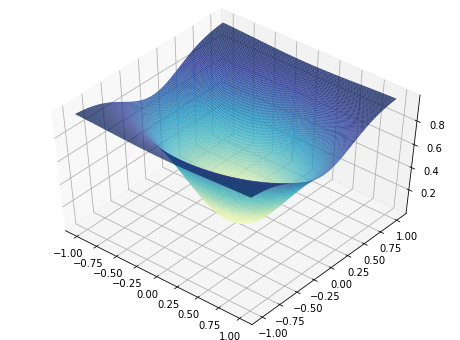

In [11]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection="3d", elev=50, azim=-50)

ax.plot_surface(np.array(x), np.array(y), np.array(z), rstride=1, cstride=1, edgecolor="none", cmap=plt.cm.YlGnBu)
plt.show()

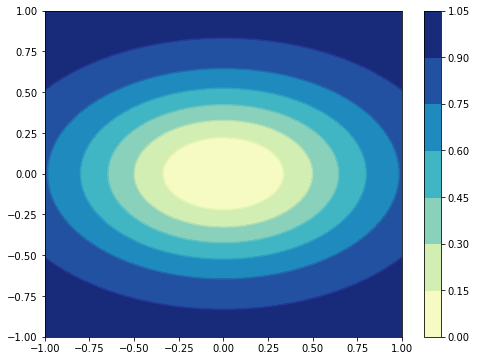

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.contourf(x, y, z, cmap=plt.cm.YlGnBu)
plt.colorbar()
plt.contour(x, y, z, cmap=plt.cm.YlGnBu)

plt.show()

In [13]:
x0 = torch.tensor([0.75, -0.75])

In [14]:
def optimize(optimizer, x0, learning_rate=1e-3, num_steps=100, **kwargs):
    x0_copy = torch.zeros_like(x0)
    x0_copy.copy_(x0)
    params = torch.nn.parameter.Parameter(x0_copy)
    optim = optimizer([params], lr=learning_rate, **kwargs)
    hist = []
    for i in range(num_steps):
        optim.zero_grad()
        params_copy = torch.zeros_like(params.data)
        params_copy.copy_(params.data)
        hist.append(params_copy)
        loss = f(*params)
        loss.backward()
        optim.step()
    return np.array(hist)

In [15]:
sgd = partial(optimize, torch.optim.SGD)
sgd_momentum = partial(optimize, torch.optim.SGD, momentum=0.9)
ada_grad = partial(optimize, torch.optim.Adagrad)
rms_prop = partial(optimize, torch.optim.RMSprop)
adam = partial(optimize, torch.optim.Adam, betas=(0.9, 0.99))

In [16]:
class TrajectoryAnimation(animation.FuncAnimation):
    
    def __init__(self, *paths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths

        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]
        self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                       for line in self.lines]

        super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line, point in zip(self.lines, self.points):
            line.set_data([], [])
            point.set_data([], [])
        return self.lines + self.points

    def animate(self, i):
        for line, point, path in zip(self.lines, self.points, self.paths):
            line.set_data(*path[::,:i])
            point.set_data(*path[::,i-1:i])
        return self.lines + self.points

In [17]:
paths = [sgd(x0, learning_rate=2e-2).T,
         sgd_momentum(x0, learning_rate=2e-2, dampening=0.9).T,
         ada_grad(x0, learning_rate=2e-2).T,
         rms_prop(x0, learning_rate=2e-2).T,
         adam(x0, learning_rate=2e-2).T]
methods = ["SGD", "SGD+Momentum", "AdaGrad", "RMSProp", "Adam"]

(-1.0, 1.0, -1.0, 1.0)

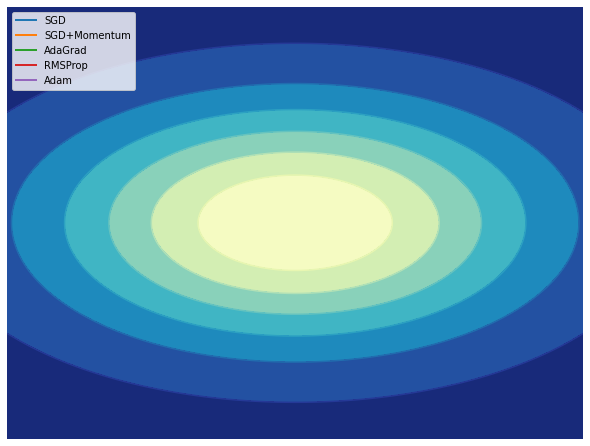

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))

fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
plt.contourf(x, y, z, cmap=plt.cm.YlGnBu)
plt.contour(x, y, z, cmap=plt.cm.YlGnBu)

anim = TrajectoryAnimation(*paths, labels=methods, ax=ax)

plt.legend(loc='upper left')
plt.axis("off")

In [19]:
anim.save("optimizers-animation.gif", writer="imagemagick")